In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numpy as np
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


In [3]:
import librosa
import librosa.display
import IPython.display as ipd

import sys
sys.setrecursionlimit(10000) # 10000 is an example, try with different values
sys.path.append("/home/muncok/DL/projects/sv_system/")

In [4]:
from dnn.parser import ConfigBuilder
import dnn.data.dataset as dset
import dnn.train.model as mod
from dnn.si_train import set_seed
from pydub import AudioSegment

ModuleNotFoundError: No module named 'dnn'

In [ ]:
from dnn.data.manage_audio import preprocess_from_path
from torch.autograd import Variable
import torch

def embed(config, model, audio_path, splice_frame):                           
    data = preprocess_from_path(config, audio_path)
    if not config["no_cuda"]:                                   
        torch.cuda.set_device(config["gpu_no"])                 
        model.cuda()                                            
    model.eval() 
    print(data.shape)
    data = torch.split(data, splice_frame, dim=0)
    data = torch.stack(data[:-1], dim=0)
    data_in = Variable(data, requires_grad=False)
    if not config["no_cuda"]:                                   
        data_in = data_in.cuda()                                
    feature = model.embed(data_in).cpu().data           
    return feature                                              

In [ ]:
def draw_in_feature(config, sound_files, in_feature='mfcc'):
    t = len(sound_files)
    plt.figure(figsize=(8, 4*t))
    for i, sound_file in enumerate(sound_files):
        feature = preprocess_from_path(config, sound_file, in_feature)
        plt.subplot(t,1,i+1)
        librosa.display.specshow(feature.numpy().T, 
                                 x_axis='time', y_axis='mel',
                                 sr=16000, hop_length=160, 
                                 fmin=20, fmax=4000)
        plt.colorbar()
        word = sound_file.split("/")[-2]
        file = sound_file.split("/")[-1]
        plt.title("{}, {}, {}".format(in_feature, word, file))
        plt.tight_layout()

### LDA Transformation

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import pickle
def lda_tf(emb, lda_path):
    lda_model = pickle.load(open(lda_path, "rb"))
    return torch.from_numpy(lda_model.transform(emb).astype(np.float32))

In [7]:
import torch.nn.functional as F
def cos_sim(a, b, lda=False):
    if lda:
        print(F.cosine_similarity(lda_tf(a), lda_tf(b)))
    else:
        print(F.cosine_similarity(a, b))

### SI_Model

In [8]:
global_config = dict(no_cuda=False,  gpu_no=0)

builder = ConfigBuilder(
                dset.SpeechDataset.default_config(),
                global_config)
parser = builder.build_argparse()
si_config = builder.config_from_argparse(parser)
si_config['model_class'] = mod.SimpleCNN

In [9]:
si_model = si_config['model_class'](small=True)

In [11]:
si_model.load_partial("models/voxc/si_train/random_train/si_voxc_0.1s_random.pt")

models/voxc/si_train/random_train/si_voxc_0.1s_random.pt is loaded


In [10]:
sound_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/right/0132a06d_nohash_0.wav"
feature = preprocess_from_path(si_config, sound_file, "fbank")

In [19]:
import torchvision
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(feature.unsqueeze(0).numpy().T)

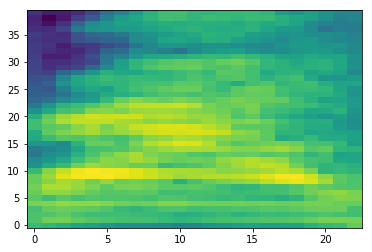

In [36]:
plt.imshow(feature.numpy().T, aspect='auto', origin='lower')

### Input Feature 

/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


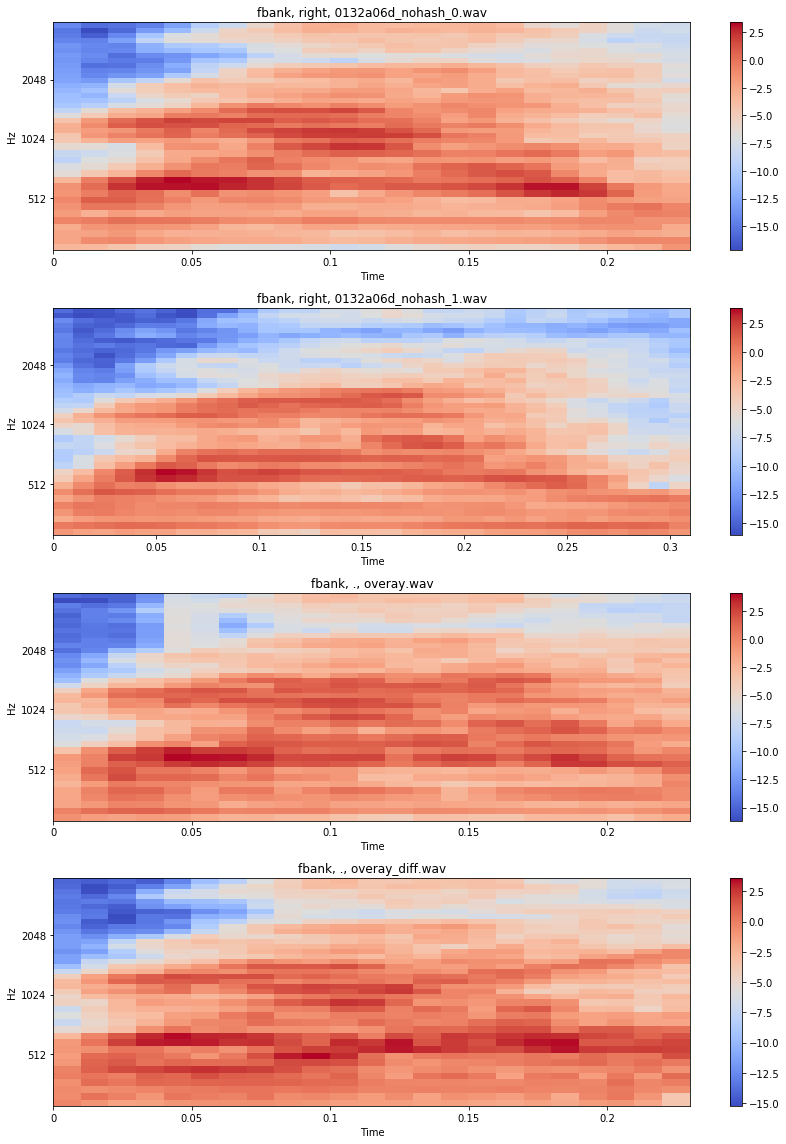

In [29]:
sound1_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/right/0132a06d_nohash_0.wav"
sound2_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/right/0132a06d_nohash_1.wav"
sound3_file = "./overay.wav"
sound4_file = "./overay_diff.wav"
draw_in_feature(si_config, [sound1_file, sound2_file, sound3_file, sound4_file], "fbank")

In [5]:
sound1_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/right/0132a06d_nohash_0.wav"
sound2_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/right/0132a06d_nohash_1.wav"
sound3_file = "./overay.wav"
sound4_file = "./overay_diff.wav"
draw_in_feature(si_config, [sound1_file, sound2_file, sound3_file, sound4_file], "fbank")

NameError: name 'si_config' is not defined

In [41]:
a = AudioSegment.from_wav("/home/muncok/DL/dataset/SV_sets/speech_commands/vad/left/0132a06d_nohash_3.wav")
b = AudioSegment.from_wav("/home/muncok/DL/dataset/SV_sets/speech_commands/vad/left/0132a06d_nohash_1.wav")

In [42]:
c = a.overlay(b)

In [43]:
c

In [45]:
AudioSegment.from_wav("overay.wav")

right, spk A

/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


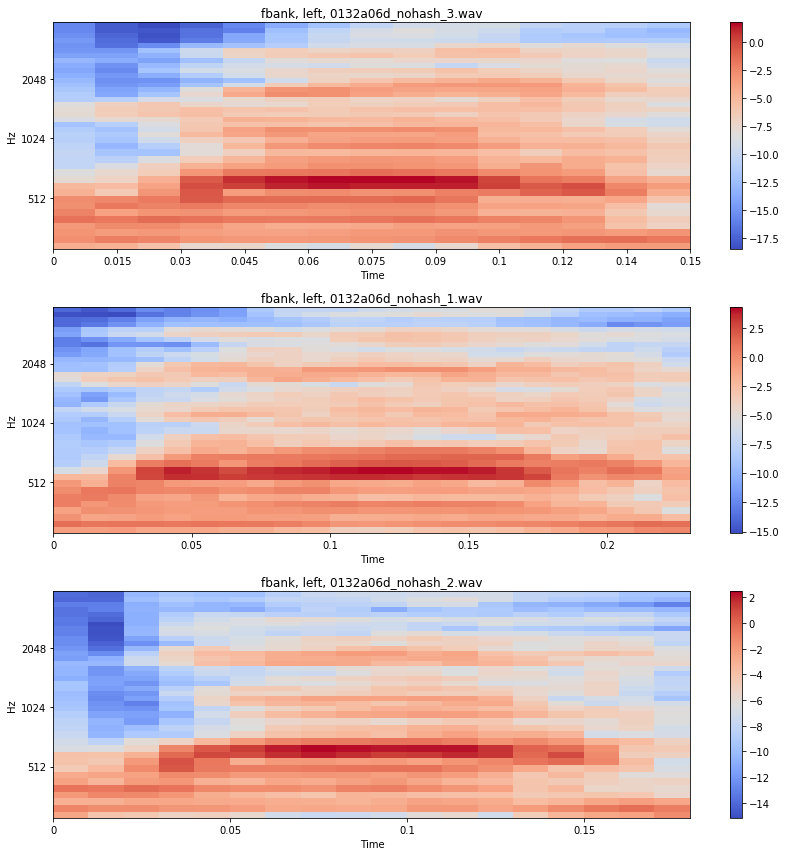

In [178]:
sound1_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/left/0132a06d_nohash_3.wav"
sound2_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/left/0132a06d_nohash_1.wav"
sound3_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/left/0132a06d_nohash_2.wav"
draw_in_feature(si_config, [sound1_file, sound2_file, sound3_file], "fbank")

right, spk B

/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


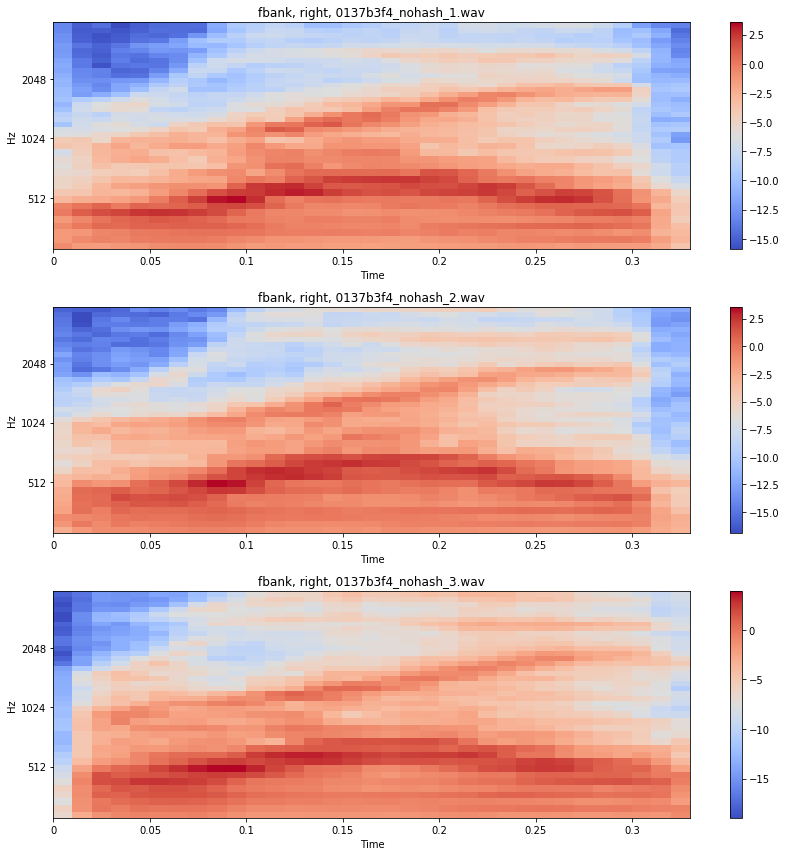

In [179]:
sound1_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/right/0137b3f4_nohash_1.wav"
sound2_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/right/0137b3f4_nohash_2.wav"
sound3_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/right/0137b3f4_nohash_3.wav"
draw_in_feature(si_config, [sound1_file, sound2_file, sound3_file], "fbank")

In [ ]:
sound1_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/right/0137b3f4_nohash_1.wav"
sound2_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/right/0137b3f4_nohash_2.wav"
sound3_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/right/0137b3f4_nohash_3.wav"
draw_in_feature(si_config, [sound1_file, sound2_file, sound3_file], "fbank")

right, spk C

/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


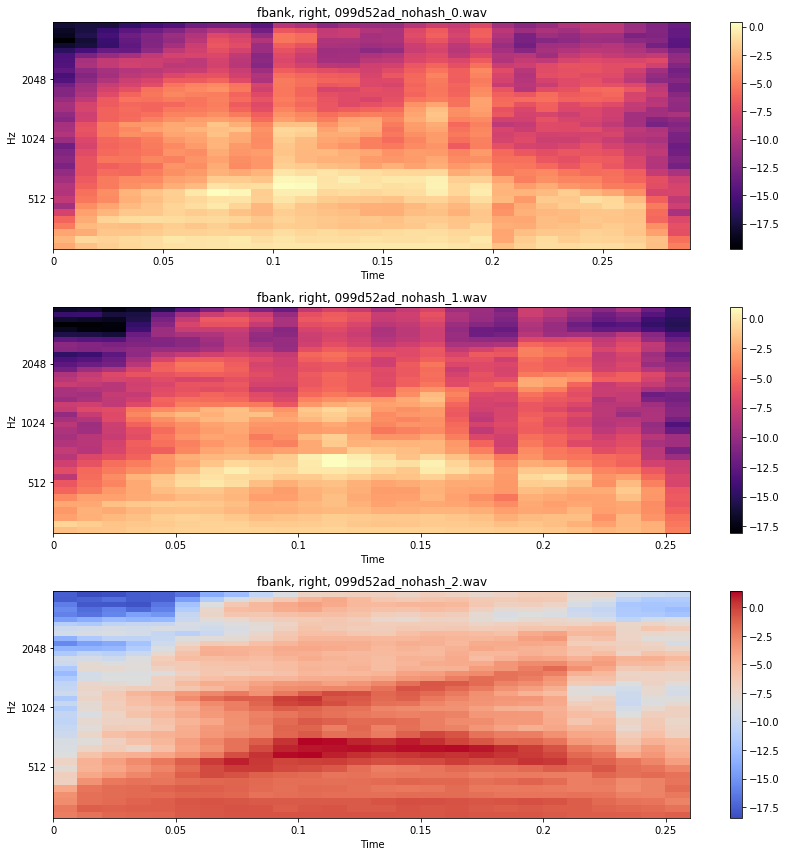

In [183]:
sound1_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/right/099d52ad_nohash_0.wav"
sound2_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/right/099d52ad_nohash_1.wav"
sound3_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/right/099d52ad_nohash_2.wav"
draw_in_feature(si_config, [sound1_file, sound2_file, sound3_file], "fbank")

In [191]:
sounda_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/left/0132a06d_nohash_3.wav"
sounda = AudioSegment.from_file(sounda_file)
sounda_embed = embed(si_config, si_model, sounda_file, splice_frame)

torch.Size([15, 40])


In [192]:
soundb_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/right/0137b3f4_nohash_1.wav"
soundb = AudioSegment.from_file(soundb_file)
soundb_embed = embed(si_config, si_model, soundb_file, splice_frame)

torch.Size([33, 40])


In [193]:
soundc_file = "/home/muncok/DL/dataset/SV_sets/speech_commands/vad/right/099d52ad_nohash_0.wav"
soundc = AudioSegment.from_file(soundc_file)
soundc_embed = embed(si_config, si_model, soundc_file, splice_frame)

torch.Size([29, 40])


Sim A and B

In [194]:
cos_sim(sounda_embed.mean(0, keepdim=True), soundb_embed.mean(0, keepdim=True), isLda)


 0.3839
[torch.FloatTensor of size 1]



Sim B and C

In [195]:
cos_sim(soundb_embed.mean(0, keepdim=True), soundc_embed.mean(0, keepdim=True), isLda)


 0.4502
[torch.FloatTensor of size 1]



Sim A and C

In [196]:
cos_sim(sounda_embed.mean(0, keepdim=True), soundc_embed.mean(0, keepdim=True), isLda)


 0.3166
[torch.FloatTensor of size 1]



## SpeechCommand

In [153]:
def audioToembed(audio):
    seg = AudioSegment.from_file(audio)
    emb = embed(si_config, si_model, audio, splice_sec)
    return seg, emb

In [149]:
si_config['input_length'] = int(16000*1)
splice_sec = 0.2

In [161]:
seg1, command1 = audioToembed("/home/muncok/DL/dataset/SV_sets/speech_commands/eight/0132a06d_nohash_1.wav")
seg2, command2 = audioToembed("/home/muncok/DL/dataset/SV_sets/speech_commands/eight/0132a06d_nohash_2.wav")

In [146]:
audioToembed(yes_command1)

In [162]:
seg1

In [160]:
seg2

In [163]:
cos_sim(command1, command2, False)
cos_sim(command1.mean(0,True), command2, False)


 0.5855
 0.6131
 0.5157
 0.4796
 0.5134
[torch.FloatTensor of size 5]


 0.5283
 0.7741
 0.6913
 0.6655
 0.6659
[torch.FloatTensor of size 5]

